# Schools in NYC based on performance scores
Data Source: 
https://data.cityofnewyork.us/Education/School-Progress-Reports-All-Schools-2009-10/ffnc-f3aa


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn import cross_validation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.cluster.hierarchical import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_context("poster")

In [2]:
df = pd.read_csv("data/School_Progress_Reports_-_All_Schools_-_2009-10.csv")

In [3]:
print df.shape
df.head()

(1677, 17)


,DBN,DISTRICT,SCHOOL,PRINCIPAL,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,2009-2010 OVERALL GRADE,2009-2010 OVERALL SCORE,2009-2010 ENVIRONMENT CATEGORY SCORE,2009-2010 ENVIRONMENT GRADE,2009-2010 PERFORMANCE CATEGORY SCORE,2009-2010 PERFORMANCE GRADE,2009-2010 PROGRESS CATEGORY SCORE,2009-2010 PROGRESS GRADE,2009-2010 ADDITIONAL CREDIT,2008-09 PROGRESS REPORT GRADE
0,01M015,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B
1,01M019,1,P.S. 019 Asher Levy,Jacqueline Flanagan,EMS,Elementary,48.94,C,35.7,6.4,B,4.9,D,24.4,B,0.0,A
2,01M020,1,P.S. 020 Anna Silver,James Lee,EMS,Elementary,57.68,A,70.3,9.3,A,7.9,C,44.1,A,9.0,A
3,01M034,1,P.S. 034 Franklin D. Roosevelt,Joyce Stallings Harte,EMS,K-8,66.75,B,53.0,6.8,B,7.4,C,33.0,B,5.8,A
4,01M063,1,P.S. 063 William McKinley,Darlene Despeignes,EMS,Elementary,57.55,B,54.0,7.8,B,7.1,C,35.8,A,3.3,B


In [50]:
cols = df.columns
print "\n".join("[%s] %s" % k for k in enumerate(cols))
print cols[9:16:2]
df = df.fillna(0)

[0] DBN
[1] DISTRICT
[2] SCHOOL
[3] PRINCIPAL
[4] PROGRESS REPORT TYPE
[5] SCHOOL LEVEL*
[6] PEER INDEX*
[7] 2009-2010 OVERALL GRADE
[8] 2009-2010 OVERALL SCORE
[9] 2009-2010 ENVIRONMENT CATEGORY SCORE
[10] 2009-2010 ENVIRONMENT GRADE
[11] 2009-2010 PERFORMANCE CATEGORY SCORE
[12] 2009-2010 PERFORMANCE GRADE
[13] 2009-2010 PROGRESS CATEGORY SCORE
[14] 2009-2010 PROGRESS GRADE
[15] 2009-2010 ADDITIONAL CREDIT
[16] 2008-09 PROGRESS REPORT GRADE
Index([u'2009-2010 ENVIRONMENT CATEGORY SCORE',
       u'2009-2010 PERFORMANCE CATEGORY SCORE',
       u'2009-2010 PROGRESS CATEGORY SCORE', u'2009-2010 ADDITIONAL CREDIT'],
      dtype='object')


In [51]:
class MultiColumnExtractor(TransformerMixin):
    def __init__(self, colnames):
        print "Initialized extractor for column %s" % colnames
        self.colnames = colnames
    def get_feature_names(self):
        return self.colnames
    def transform(self, X, **transform_params):
        print "Extracting columns [%s]" % (self.colnames,)
        return pd.DataFrame(X[self.colnames])
    def fit(self, X, y=None, **fit_params):
        return self

In [53]:
pipeline = Pipeline([
        ("columns", MultiColumnExtractor(cols[9:16:2])),
        ("features_scaled", StandardScaler())
    ])

Initialized extractor for column Index([u'2009-2010 ENVIRONMENT CATEGORY SCORE',
       u'2009-2010 PERFORMANCE CATEGORY SCORE',
       u'2009-2010 PROGRESS CATEGORY SCORE', u'2009-2010 ADDITIONAL CREDIT'],
      dtype='object')


In [54]:
cluster = AgglomerativeClustering(n_clusters=2)


In [55]:
X = pipeline.fit_transform(df)
print X.shape
cids = cluster.fit_predict(X)
cols = df.columns
df_pred = pd.concat((df[df.columns[:7]], pd.DataFrame(X, columns=cols[9:16:2]), pd.Series(cids, name="ClusterID")), axis=1)
df_pred.head()

Extracting columns [Index([u'2009-2010 ENVIRONMENT CATEGORY SCORE',
       u'2009-2010 PERFORMANCE CATEGORY SCORE',
       u'2009-2010 PROGRESS CATEGORY SCORE', u'2009-2010 ADDITIONAL CREDIT'],
      dtype='object')]
(1677, 4)


,DBN,DISTRICT,SCHOOL,PRINCIPAL,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,2009-2010 ENVIRONMENT CATEGORY SCORE,2009-2010 PERFORMANCE CATEGORY SCORE,2009-2010 PROGRESS CATEGORY SCORE,2009-2010 ADDITIONAL CREDIT,ClusterID
0,01M015,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,-0.058789,-0.965051,-0.035660,-0.998307,0
1,01M019,1,P.S. 019 Asher Levy,Jacqueline Flanagan,EMS,Elementary,48.94,-0.287271,-0.654780,-0.250515,-0.998307,0
2,01M020,1,P.S. 020 Anna Silver,James Lee,EMS,Elementary,57.68,0.540976,-0.164878,1.160368,2.049193,1
3,01M034,1,P.S. 034 Franklin D. Roosevelt,Joyce Stallings Harte,EMS,K-8,66.75,-0.173030,-0.246528,0.365403,0.965637,1
4,01M063,1,P.S. 063 William McKinley,Darlene Despeignes,EMS,Elementary,57.55,0.112572,-0.295518,0.565935,0.119110,1


1    1006
0     671
dtype: int64
[0] DBN
[1] DISTRICT
[2] SCHOOL
[3] PRINCIPAL
[4] PROGRESS REPORT TYPE
[5] SCHOOL LEVEL*
[6] PEER INDEX*
[7] 2009-2010 ENVIRONMENT CATEGORY SCORE
[8] 2009-2010 PERFORMANCE CATEGORY SCORE
[9] 2009-2010 PROGRESS CATEGORY SCORE
[10] 2009-2010 ADDITIONAL CREDIT
[11] ClusterID


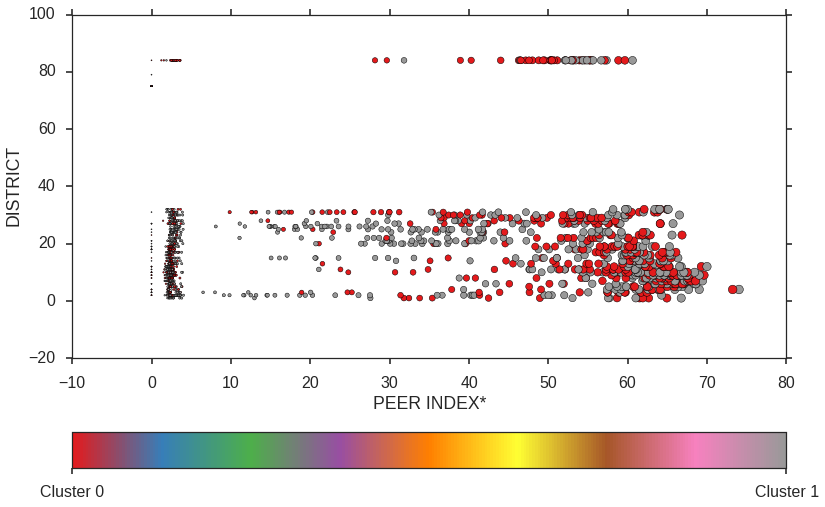

In [80]:
cols = df_pred.columns
print df_pred.ClusterID.value_counts()
print "\n".join("[%s] %s" % k for k in enumerate(df_pred.columns))
xi, yi = cols[6], cols[1]
cax = plt.scatter(df_pred[xi], df_pred[yi], c=df_pred[cols[11]], s=(1+df_pred[cols[6]]), cmap="Set1")
cbar = plt.colorbar(cax, ticks=[0,1], orientation='horizontal')
cbar.ax.set_xticklabels(['Cluster 0','Cluster 1'])  # horizontal colorbar

plt.xlabel(xi)
plt.ylabel(yi)